In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import functools as ft
from scipy.linalg import block_diag
from rich.progress import track


In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'

In [3]:
# ===========================================================================================================
# ===================================== Defining few functions for ease ====================================
# ==========================================================================================================

# --------- Conjugate Transpose --------

def conjT(A # Matrix 
         ):
    B = np.conj(A)
    B = np.transpose(B)
    return B

# --- Vector norm and Vector product

def vec_norm(v # column vector
            ):
    norm = conjT(v)@v
    return np.sqrt(norm[0,0])

def vec_prod(u,v # column vectors
            ):
    norm = conjT(u)@v
    return norm[0,0]


def f(t1,t2):
    return np.heaviside(t1) - np.heaviside(t2)


-----------

In [4]:
N = 2**4 # lattice sites
pos = np.eye(N) # position space
coin = np.eye(4)  # coin space

In [5]:
# Coin Switch

UD = np.outer(coin[3],coin[0]) # Takes from U to D
DU = np.outer(coin[0],coin[3]) 
LR = np.outer(coin[2],coin[1]) 
RL = np.outer(coin[1],coin[2])  

UU = np.outer(coin[0],coin[0])
DD = np.outer(coin[3],coin[3])
LL = np.outer(coin[1],coin[1])
RR = np.outer(coin[2],coin[2])

In [6]:
# Constructing Shift Operator -- Periodic boundary condition 

shift_down = np.kron(np.eye(N),np.roll(np.eye(N), 1, axis=0))
shift_up = np.kron(np.eye(N),np.roll(np.eye(N), -1, axis=0))
shift_left = np.kron(np.roll(np.eye(N), 1, axis=0),np.eye(N))
shift_right = np.kron(np.roll(np.eye(N), -1, axis=0),np.eye(N))

shift = np.kron(UD,shift_up) + np.kron(DU,shift_down) + np.kron(LR,shift_left) + np.kron(RL,shift_right)

In [7]:
print('Is shift operator unitary?', np.allclose(shift@conjT(shift),np.eye(N**2*4)))

Is shift operator unitary? True


In [8]:
# Grover's Coin Operator 

Qdim = 4
Grover_OP = 2*np.ones((Qdim,Qdim))/Qdim - np.eye(Qdim)

# Evolution operator for the walk

Evolution_OP = shift@np.kron(Grover_OP,np.eye(N**2))



In [9]:
def ORACLE(marked_points):
    # basis = []
    mm = np.zeros((N**2,N**2))
    if len(marked_points) == 0:
        return np.eye(Qdim*N**2)
    else:
        for i in range(len(marked_points)):
            xx = np.zeros((N,1)); yy = np.zeros((N,1))
            coordinate = marked_points
            xx[coordinate[0],0] = 1; yy[coordinate[1],0] = 1
            basis = np.kron(xx,yy)
            mm = mm + basis@conjT(basis)

        R = np.eye(Qdim*N**2) - np.kron((2*np.ones((Qdim,Qdim))/Qdim),mm)
    return R


---------------------

In [3]:
T = 8  # Amplification Time 
τ = 2 # Particle's velocity 

m = int(T/τ) # number of layers

Tf = 20 # final time 
ti = 0 # real time 

In [5]:
N = 10

In [10]:
trajectory = []

position = [[np.random.randint(0,N),np.random.randint(0,N)] for i in range(int(Tf/τ))]

for i in range(Tf):
    position_at_ti = []

    for j in range(m):
        if i >= τ*j:
            position_at_ti.append(position[j + m*int((i-j*τ)/T)])
        else:
            position_at_ti.append([])
            
    trajectory.append(position_at_ti)

In [11]:
trajectory

[[[2, 6], [], [], []],
 [[2, 6], [], [], []],
 [[2, 6], [7, 2], [], []],
 [[2, 6], [7, 2], [], []],
 [[2, 6], [7, 2], [6, 7], []],
 [[2, 6], [7, 2], [6, 7], []],
 [[2, 6], [7, 2], [6, 7], [1, 7]],
 [[2, 6], [7, 2], [6, 7], [1, 7]],
 [[0, 2], [7, 2], [6, 7], [1, 7]],
 [[0, 2], [7, 2], [6, 7], [1, 7]],
 [[0, 2], [0, 6], [6, 7], [1, 7]],
 [[0, 2], [0, 6], [6, 7], [1, 7]],
 [[0, 2], [0, 6], [3, 4], [1, 7]],
 [[0, 2], [0, 6], [3, 4], [1, 7]],
 [[0, 2], [0, 6], [3, 4], [5, 2]],
 [[0, 2], [0, 6], [3, 4], [5, 2]],
 [[5, 6], [0, 6], [3, 4], [5, 2]],
 [[5, 6], [0, 6], [3, 4], [5, 2]],
 [[5, 6], [2, 1], [3, 4], [5, 2]],
 [[5, 6], [2, 1], [3, 4], [5, 2]]]

In [79]:
evolution_op_list = []
for i in range(m):
    evolution_op_list.append(Evolution_OP)

evolution_op = ft.reduce(block_diag,evolution_op_list)
  
Ψ0 = np.ones((Qdim*N**2*m,1))
Ψ0 = Ψ0/vec_norm(Ψ0)
Ψt = np.copy(Ψ0)
P = []

for i in tqdm(range(Tf)):
    position_at_ti = trajectory[i]
    
    oracle_list = []
    
    for j in range(m):
        oracle_list.append(ORACLE(position_at_ti[j]))
    
    oracle = ft.reduce(block_diag,oracle_list)
    
    U = evolution_op@oracle 
    
    Pt = []
    for k in range(m):
        ψt = Ψt[k*Qdim*N**2:k*Qdim*N**2 + Qdim*N**2]
        P_layer = np.zeros((N,N))
        for xx in range(N):
            xket = np.zeros((N,1))
            xket[xx,0] = 1
            for yy in range(N):
                yket = np.zeros((N,1))
                yket[yy,0] = 1
                basis = np.kron(xket,yket)
                pt = 0
                for ii in range(4):
                    ϕ = np.kron(coin[:,[ii]],basis)
                    pt = pt + np.absolute(conjT(ϕ)@ψt)**2
                P_layer[xx,yy] = pt
        Pt.append(P_layer)
    P.append(Pt)

    Ψt = U@Ψt

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:09<00:00,  2.49s/it]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 487.80it/s]


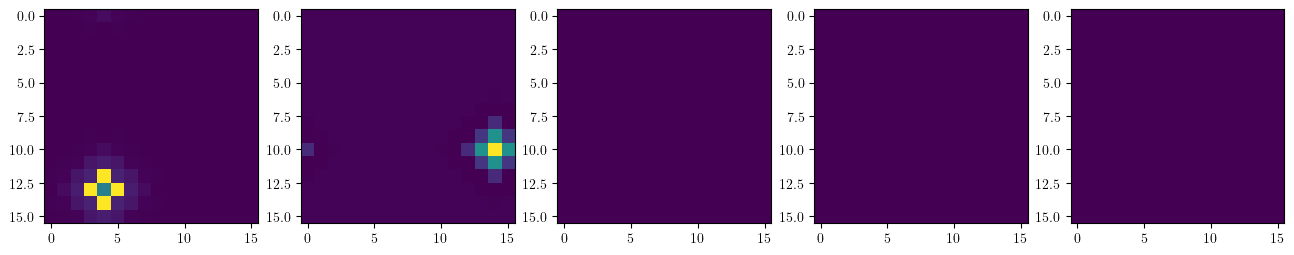

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation



# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
fig, axs = plt.subplots(1,m,figsize=(16, 4))

ims = []
for i in tqdm(range(10)):
    
    for ii in range(m):
        ax = axs[ii]
        ax.imshow(P[i][ii], animated=True)

    if i == 0:
        for ii in range(m):
            ax = axs[ii]
            im = ax.imshow(P[i][0])  # show an initial one first
    
    ims.append([im])

    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=False,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
ani.save("movie.gif")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

In [75]:
m = 5

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm


# Create subplots
fig, axs = plt.subplots(1, m, figsize=(16, 4))

# Initialize a list of lists for artists in each frame
ims = []

# Loop through frames
for i in tqdm(range(Tf)):
    artists_in_frame = []  # List to store artists for this frame
    
    for ii in range(m):
        ax = axs[ii]
        im = ax.imshow(P[i][ii], animated=True)
        artists_in_frame.append(im)  # Append the subplot's artist
    
    ims.append(artists_in_frame)  # Append the list of artists for this frame

# Create the animation
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

# Save the animation as a GIF
ani.save("movie.gif")

plt.show()


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 321.83it/s]
